## Training for H1 rapgap MC with reconstructed observables as input.
### This uses a single DNN with all inputs (electron, HFS, photons)
Adjust Huber delta to 0.01.


In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl

from datetime import datetime
import subprocess


In [2]:
#has_gpu = False

has_gpu = True

training_name = 'version1a'




#--- Hyperparameter settings.

#max_events =   120000
#max_events =   600000
max_events =  3000000
#max_events = 15000000
#max_events = 1e9



learning_rate_setval_reg = 1e-5  
batch_size_setval = 1024
max_epochs = 5000
dropout_setval = 0.0
amsgrad_setval = False
patience_setval = 40
#huber_delta = 0.01
huber_delta = 1





#input_file_rapgap = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2021-10-14-v5a/all-h1-django.root'

#input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-rapgap.root'
#input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/test-django.root'

input_file_rapgap = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root'
input_file_django = '/data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root'


parfile = open( '%s-setup.txt' % training_name,'w')

parfile.write('%s\n' % datetime.now() )
parfile.write('training_name : %s\n' % training_name )
parfile.write('input_file_rapgap : %s\n' % input_file_rapgap )
parfile.write('input_file_django : %s\n' % input_file_django )
parfile.write('max_events : %d\n' % max_events )
parfile.write('learning_rate_setval_reg : %g\n' % learning_rate_setval_reg )
parfile.write('batch_size_setval : %d\n' % batch_size_setval )
parfile.write('max_epochs : %d\n' % max_epochs )
parfile.write('dropout_setval : %g\n' % dropout_setval )
parfile.write('amsgrad_setval : %g\n' % amsgrad_setval )
parfile.write('patience_setval : %g\n' % patience_setval )
parfile.write('huber_delta : %g\n' % huber_delta )




parfile.close()

print('\n\n--- Training parameters file: %s-setup.txt\n' % training_name )
print( subprocess.getoutput('cat %s-setup.txt' % training_name ) )
print('\n\n')



--- Training parameters file: version1a-setup.txt

2023-06-25 15:55:12.912649
training_name : version1a
input_file_rapgap : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-rapgap.root
input_file_django : /data/owen/DIS-reco/h1-2023-06-23-v6c/all-h1-django.root
max_events : 3000000
learning_rate_setval_reg : 1e-05
batch_size_setval : 1024
max_epochs : 5000
dropout_setval : 0
amsgrad_setval : 0
patience_setval : 40
huber_delta : 1





In [3]:
%%time


ur_file_rapgap = uproot3.open(input_file_rapgap)

print (ur_file_rapgap.keys()) 
ur_tree_rapgap = ur_file_rapgap['Rapgap/minitree']
print(ur_tree_rapgap)
ur_tree_rapgap.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_rapgap   =  ur_tree_rapgap.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_rapgap.shape[0] )

[b'Rapgap;1']
<TTree b'minitree' at 0x7f4acdeb3250>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [4]:
%%time


ur_file_django = uproot3.open(input_file_django)

print (ur_file_django.keys()) 
ur_tree_django = ur_file_django['Django/minitree']
print(ur_tree_django)
ur_tree_django.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df_django   =  ur_tree_django.pandas.df(
    ['has_isr','has_fsr',
     'tower_sum_40','n_towers_40', 
     'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'phi_pho_closest_to_ebeam',
     'obs_x', 'obs_y', 'obs_Q2',
     'from_tlv_gen_Q2','from_tlv_gen_x','from_tlv_gen_y',
     'obs_e_e','obs_e_pz','obs_e_pt','obs_e_phi',
     'obs_hfs_e','obs_hfs_pz','obs_hfs_pt','obs_hfs_phi',
     'obs_dphi',
     'Empz', 'obs_e_trk_e',
     'beam_e_e', 'wgt',
     'gen_e_e', 'gen_e_pz', 'gen_e_pt', 'gen_e_eta', 'gen_e_phi',
     'obs_e_eta',
     'gen_hfs_e', 'gen_hfs_pz', 'gen_hfs_pt', 'gen_hfs_eta',
     'gen_hfs_etacut_e','gen_hfs_etacut_pz','gen_hfs_etacut_pt','gen_hfs_etacut_eta', 'gen_hfs_etacut_phi',
     'obs_hfs_eta',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df_django.shape[0] )

[b'Django;1']
<TTree b'minitree' at 0x7f4acdd1d840>
wgt                        (no streamer)              asdtype('>f4')
Empz                       (no streamer)              asdtype('>f4')
from_tlv_gen_Q2            (no streamer)              asdtype('>f4')
from_tlv_gen_x             (no streamer)              asdtype('>f4')
from_tlv_gen_y             (no streamer)              asdtype('>f4')
beam_e_e                   (no streamer)              asdtype('>f4')
beam_p_e                   (no streamer)              asdtype('>f4')
has_isr                    (no streamer)              asdtype('int8')
has_fsr                    (no streamer)              asdtype('int8')
gen_e_e                    (no streamer)              asdtype('>f4')
gen_e_pz                   (no streamer)              asdtype('>f4')
gen_e_pt                   (no streamer)              asdtype('>f4')
gen_e_phi                  (no streamer)              asdtype('>f4')
gen_e_eta                  (no streamer)         

In [5]:
pandas_df_rapgap.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_rapgap.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_rapgap.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_rapgap.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_rapgap.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_rapgap.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_rapgap.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_rapgap.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_rapgap.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_rapgap.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_rapgap.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_rapgap.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_rapgap.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [6]:
pandas_df_django.eval( 'obs_hfs_Empz = obs_hfs_e - obs_hfs_pz', inplace=True )
pandas_df_django.eval( 'obs_e_Empz = obs_e_e - obs_e_pz', inplace=True )

pandas_df_django.eval( 'obs_event_Empz = obs_hfs_Empz + obs_e_Empz', inplace=True )

pandas_df_django.eval( 'rot_pt1 = 0.70710678 * obs_hfs_pt - 0.70710678 * obs_e_pt', inplace=True )
pandas_df_django.eval( 'rot_pt2 = 0.70710678 * obs_hfs_pt + 0.70710678 * obs_e_pt', inplace=True )

pandas_df_django.eval( 'rot_Empz1 = 0.70710678 * obs_hfs_Empz - 0.70710678 * obs_e_Empz', inplace=True )
pandas_df_django.eval( 'rot_Empz2 = 0.70710678 * obs_hfs_Empz + 0.70710678 * obs_e_Empz', inplace=True )

pandas_df_django.eval( 'gen_log_x = log(from_tlv_gen_x)', inplace=True )
pandas_df_django.eval( 'gen_log_y = log(from_tlv_gen_y)', inplace=True )
pandas_df_django.eval( 'gen_log_Q2 = log(from_tlv_gen_Q2)', inplace=True )

pandas_df_django.eval( 'e_ecal_over_trk_ratio = tower_sum_40/obs_e_trk_e', inplace=True )
pandas_df_django.eval( 'e_ecal_over_trk_ratio = (e_ecal_over_trk_ratio<4)*e_ecal_over_trk_ratio + (e_ecal_over_trk_ratio>4)*4', inplace=True )

pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = obs_e_phi - phi_pho_closest_to_ebeam', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (abs(dphi_pho_closest_to_ebeam)<3.14159265)*(dphi_pho_closest_to_ebeam)+(dphi_pho_closest_to_ebeam>3.14159265)*(dphi_pho_closest_to_ebeam-2*3.14159265) + (dphi_pho_closest_to_ebeam<-3.14159265)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (dphi_pho_closest_to_ebeam>0)*dphi_pho_closest_to_ebeam + (dphi_pho_closest_to_ebeam<0)*(dphi_pho_closest_to_ebeam+2*3.14159265)', inplace=True )
pandas_df_django.eval( 'dphi_pho_closest_to_ebeam = (phi_pho_closest_to_ebeam!=0)*(dphi_pho_closest_to_ebeam)+(phi_pho_closest_to_ebeam==0)*(-1)', inplace=True )

pandas_df_django.eval( 'e_pho_closest_to_ebeam = (e_pho_closest_to_ebeam<30)*e_pho_closest_to_ebeam + (e_pho_closest_to_ebeam>30)*30', inplace=True )

pandas_df_django.eval( 'n_towers_40 = (n_towers_40<7)*n_towers_40 + (n_towers_40>=7)*7', inplace=True  )

pandas_df_django.eval( 'has_norad = (has_isr==0) and (has_fsr==0)', inplace=True )

In [7]:


pandas_df_rapgap.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_rapgap.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [8]:


pandas_df_django.eval( 'obs_ptbal = 1. - obs_e_pt / obs_hfs_pt', inplace=True )
pandas_df_django.eval( 'obs_pzbal = 1. - (obs_hfs_Empz + obs_e_Empz)/2./beam_e_e', inplace=True )



In [9]:
pandas_df_rapgap.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

In [10]:
pandas_df_django.eval( 'gen_dphi_etacut = (gen_e_phi - gen_hfs_etacut_phi) + ((gen_e_phi - gen_hfs_etacut_phi)<0)*2*3.14159 - ((gen_e_phi - gen_hfs_etacut_phi)>2*3.14159)*2*3.14159', inplace=True )

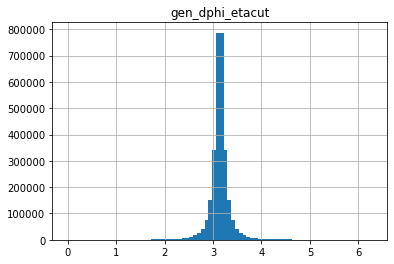

In [11]:
pandas_df_django.hist( column=['gen_dphi_etacut'], bins=80)
plt.show()

## Apply any event selection here.

In [12]:
pandas_df_rapgap = pandas_df_rapgap.query('Empz > 0')

pandas_df_rapgap = pandas_df_rapgap.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_rapgap = pandas_df_rapgap.query('obs_hfs_pt > 0')

pandas_df_rapgap = pandas_df_rapgap.query('from_tlv_gen_Q2 > 200')

pandas_df_rapgap = pandas_df_rapgap.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_rapgap = pandas_df_rapgap.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_rapgap:  %d ' % pandas_df_rapgap.shape[0] )



 Number of entries in pandas_df_rapgap:  613773 


In [13]:
pandas_df_django = pandas_df_django.query('Empz > 0')

pandas_df_django = pandas_df_django.query('obs_event_Empz > 46 and obs_event_Empz < 62')

pandas_df_django = pandas_df_django.query('obs_hfs_pt > 0')

pandas_df_django = pandas_df_django.query('from_tlv_gen_Q2 > 200')

pandas_df_django = pandas_df_django.query('e_ecal_over_trk_ratio > 0')

#-- 2023-06-23 : remove small fraction of events that have gen_hfs_etacut_e = 0

pandas_df_django = pandas_df_django.query('gen_hfs_etacut_e > 0')

print('\n\n Number of entries in pandas_df_django:  %d ' % pandas_df_django.shape[0] )



 Number of entries in pandas_df_django:  564057 


In [14]:
pandas_df_rapgap

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
23,0,0,24.247692,1,-0.182699,0.144760,2.422777,0.015283,0.019567,0.009369,...,43.001450,-4.329937,-1.276337,5.922210,1.071315,0.428013,True,0.060719,-0.101689,3.202085
36,0,1,13.348120,1,-1.709016,0.566964,-0.436204,0.003809,0.002255,0.004362,...,37.739708,-5.503805,-0.571310,5.453369,0.988650,2.755722,False,-0.035760,0.033116,3.166307
45,0,0,25.104801,1,-0.021559,1.420366,2.370969,0.013934,0.019074,0.008570,...,42.132053,-4.499992,-1.604122,5.424370,2.409008,3.302941,True,0.168212,-0.079415,3.160574
47,0,1,20.143602,1,0.018809,0.729400,-1.816074,0.007061,0.004471,0.008294,...,37.633305,-4.799874,-1.136600,5.592010,1.761387,2.691795,False,0.091957,0.035842,3.144557
56,1,0,32.968731,1,0.195189,0.114277,0.189013,0.092370,0.113946,0.127623,...,38.093636,-1.782004,-2.935359,6.801494,0.950580,3.264253,False,0.052082,0.024048,3.155321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999978,0,0,29.941027,1,1.322684,0.225233,-1.767398,0.044368,0.048523,0.059957,...,37.481941,-2.872268,-1.924640,6.731575,2.845239,2.932869,True,0.094121,0.039720,3.140613
2999984,0,0,25.384007,1,0.758430,0.135375,-1.940322,0.013417,0.007338,0.019171,...,37.511471,-3.935594,-2.249312,5.343578,1.021598,0.233744,True,0.047993,0.038963,3.158126
2999988,0,1,24.123011,1,-0.261212,3.840036,-0.663984,0.012221,0.015808,0.009090,...,41.129143,-4.652722,-1.352999,5.522763,4.000000,3.402529,False,-0.057863,-0.053721,3.155354


In [15]:
pandas_df_django

,has_isr,has_fsr,tower_sum_40,n_towers_40,eta_pho_closest_to_ebeam,e_pho_closest_to_ebeam,phi_pho_closest_to_ebeam,obs_x[0],obs_x[1],obs_x[2],...,rot_Empz2,gen_log_x,gen_log_y,gen_log_Q2,e_ecal_over_trk_ratio,dphi_pho_closest_to_ebeam,has_norad,obs_ptbal,obs_pzbal,gen_dphi_etacut
entry,,,,,,,,,,,,,,,,,,,,,
20,0,0,17.255196,1,-1.066193,0.240274,1.518299,0.004745,0.002059,0.005654,...,37.362167,-5.230584,-0.867193,5.430706,0.931784,2.221198,True,0.123451,0.042788,3.177054
22,0,0,29.893789,1,0.895007,0.601942,2.087080,0.052515,0.058272,0.067616,...,38.152119,-2.721840,-2.399088,6.407556,0.984936,2.996598,True,-0.094159,0.022550,3.175841
27,0,0,23.783131,1,-0.131410,0.446848,-1.933851,0.011714,0.016146,0.008042,...,41.864983,-4.471905,-1.468582,5.587996,1.080399,2.321987,True,0.317030,-0.072573,3.076885
33,1,0,24.646885,1,1.005825,0.120665,0.242550,0.015225,0.018389,0.011058,...,41.343658,-4.208622,-1.516757,5.799310,1.080347,1.063548,False,0.240941,-0.059217,3.212621
38,0,0,12.380091,1,-2.888133,1.764309,-0.540577,0.003480,0.003441,0.003494,...,38.996613,-5.732018,-0.448362,5.348104,0.986371,3.510371,True,-0.131654,0.000914,3.076051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999970,1,0,21.685556,1,-2.256334,8.394147,2.447153,0.008636,0.009761,0.007985,...,39.685410,-1.904118,-3.819149,5.458082,1.049069,6.162529,False,-0.692709,-0.016733,3.082457
2999975,0,0,23.934727,1,0.277469,0.352661,1.015150,0.010451,0.008657,0.011655,...,38.363922,-4.495461,-1.628446,5.404577,0.980746,3.396799,True,-0.041800,0.017124,3.163761
2999981,0,1,53.966328,1,2.628084,0.729838,2.014559,0.310944,0.592958,0.658529,...,37.037674,-0.519238,-2.862104,8.147141,1.068173,2.003499,False,-0.084287,0.051102,3.139594


## Rapgap plots

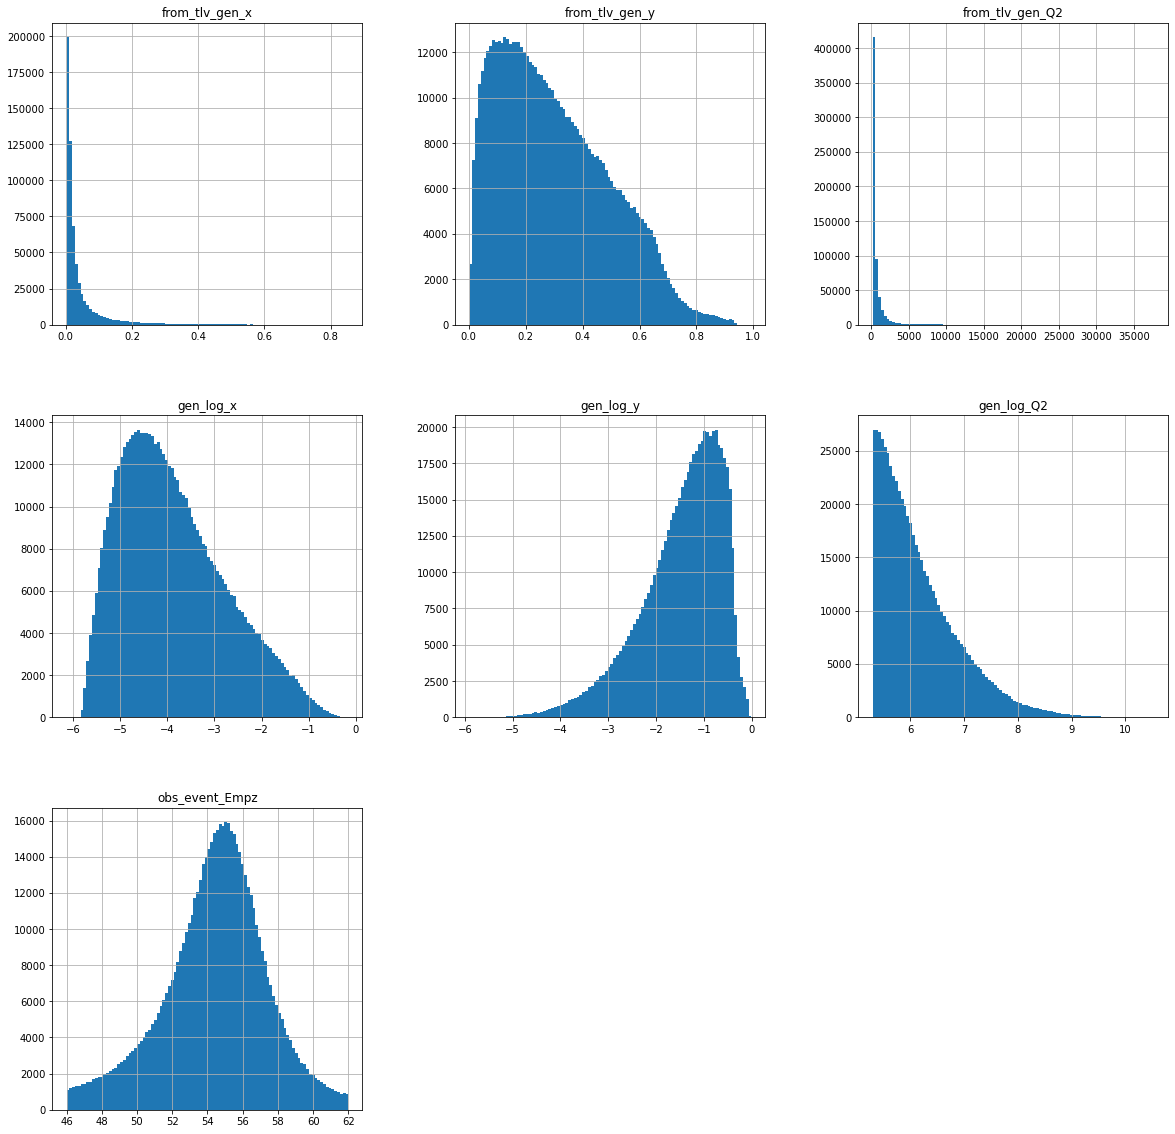

In [16]:
pandas_df_rapgap.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz', 
                        ])
plt.show()

## Django plots

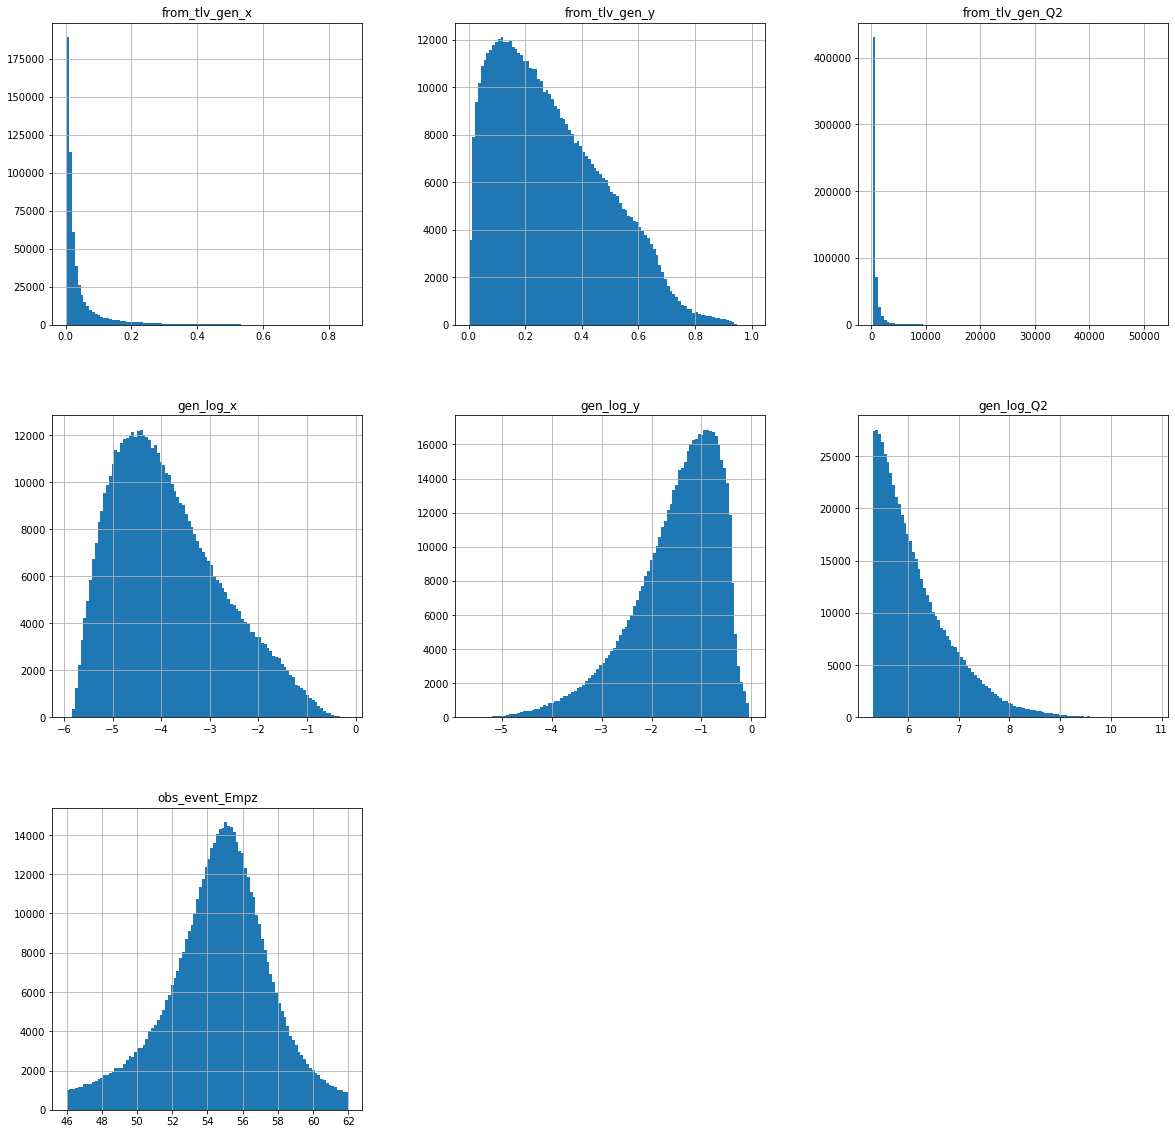

In [17]:
pandas_df_django.hist( figsize=(20,20), bins=100, column=['from_tlv_gen_x','from_tlv_gen_y','from_tlv_gen_Q2',
                        'gen_log_x','gen_log_y','gen_log_Q2','obs_event_Empz', 
                        ])
plt.show()

## Comparison of gen x, y, Q2

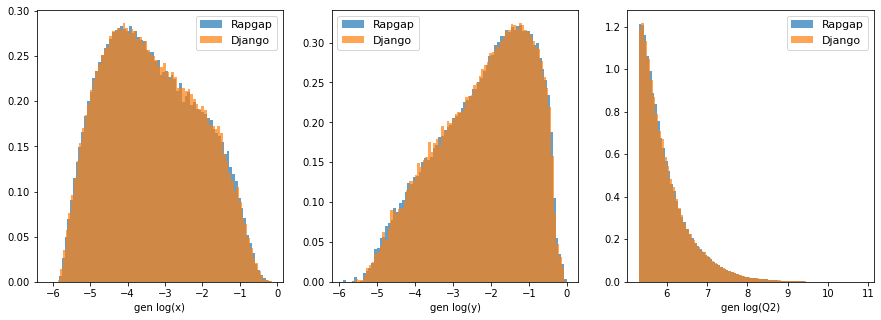

In [18]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

hbins=80
halpha=0.7

ax[0].hist( pandas_df_rapgap['gen_log_x'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0].hist( pandas_df_django['gen_log_x'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1].hist( pandas_df_rapgap['gen_log_y'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1].hist( pandas_df_django['gen_log_y'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2].hist( pandas_df_rapgap['gen_log_Q2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2].hist( pandas_df_django['gen_log_Q2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )


ax[0].set_xlabel('gen log(x)')
ax[1].set_xlabel('gen log(y)')
ax[2].set_xlabel('gen log(Q2)')

ax[0].legend( loc='best', fontsize=11)
ax[1].legend( loc='best', fontsize=11)
ax[2].legend( loc='best', fontsize=11)

plt.show()

## Rapgap ISR/FSR vars

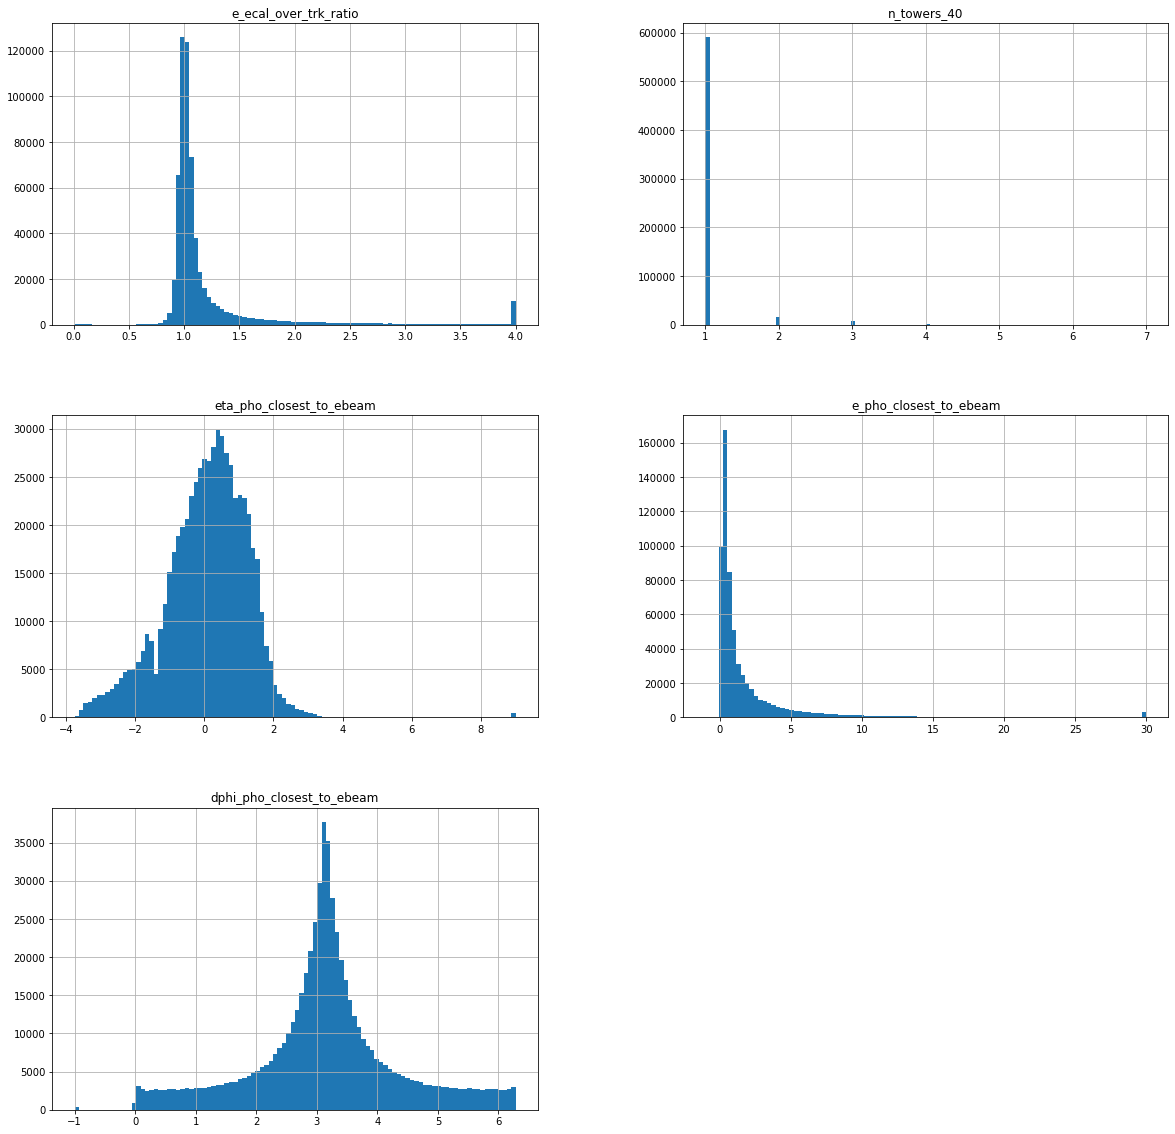

In [19]:

pandas_df_rapgap.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


## Django ISR/FSR vars

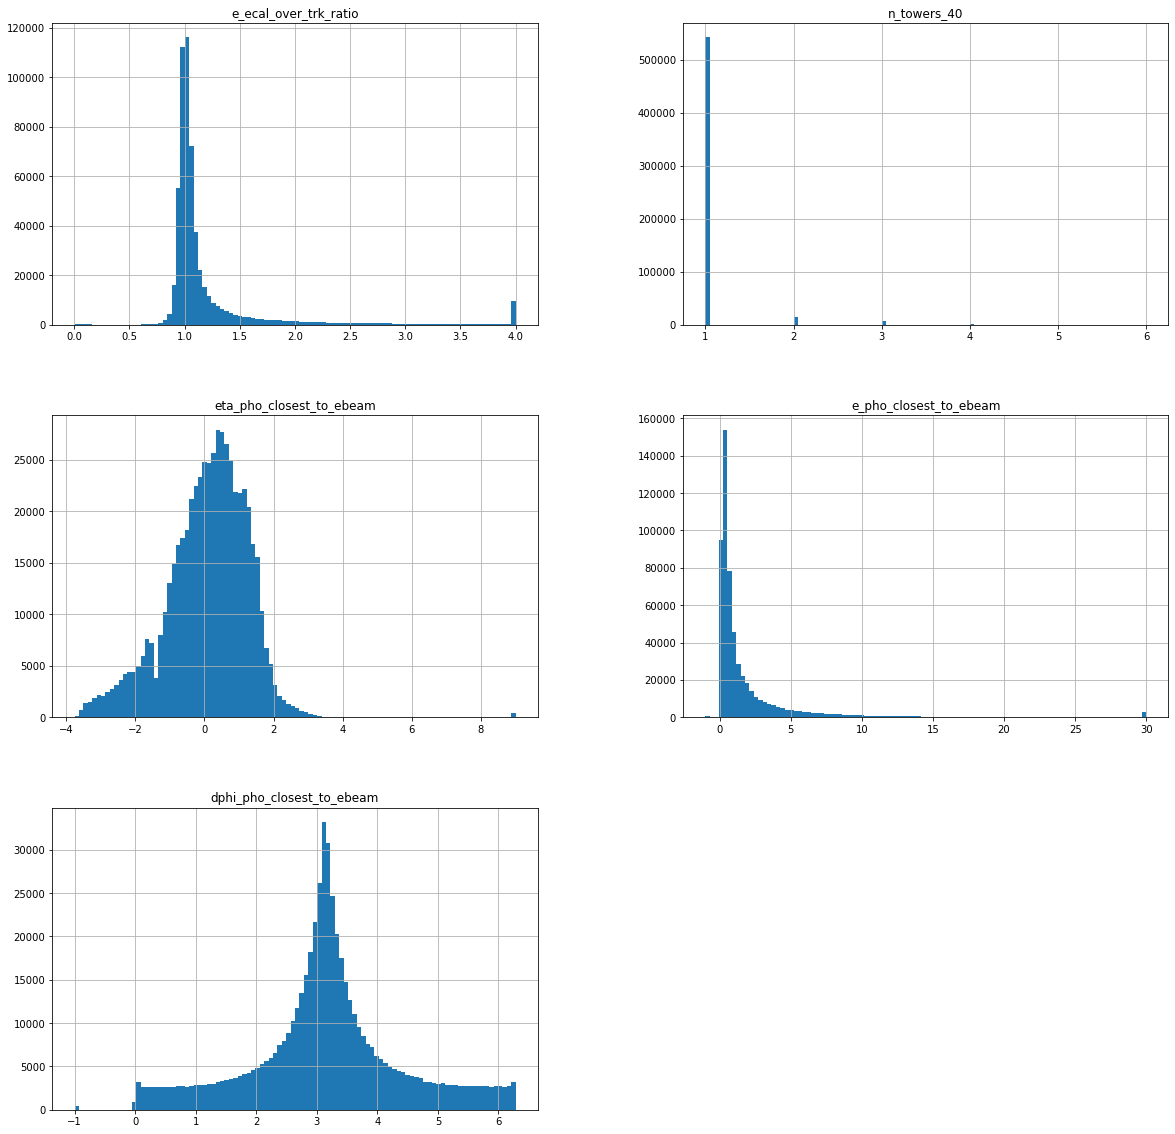

In [20]:

pandas_df_django.hist( figsize=(20,20), bins=100, column=[
                        'e_ecal_over_trk_ratio','n_towers_40',
                        'eta_pho_closest_to_ebeam','e_pho_closest_to_ebeam', 'dphi_pho_closest_to_ebeam'])

plt.show()


## Rapgap plots

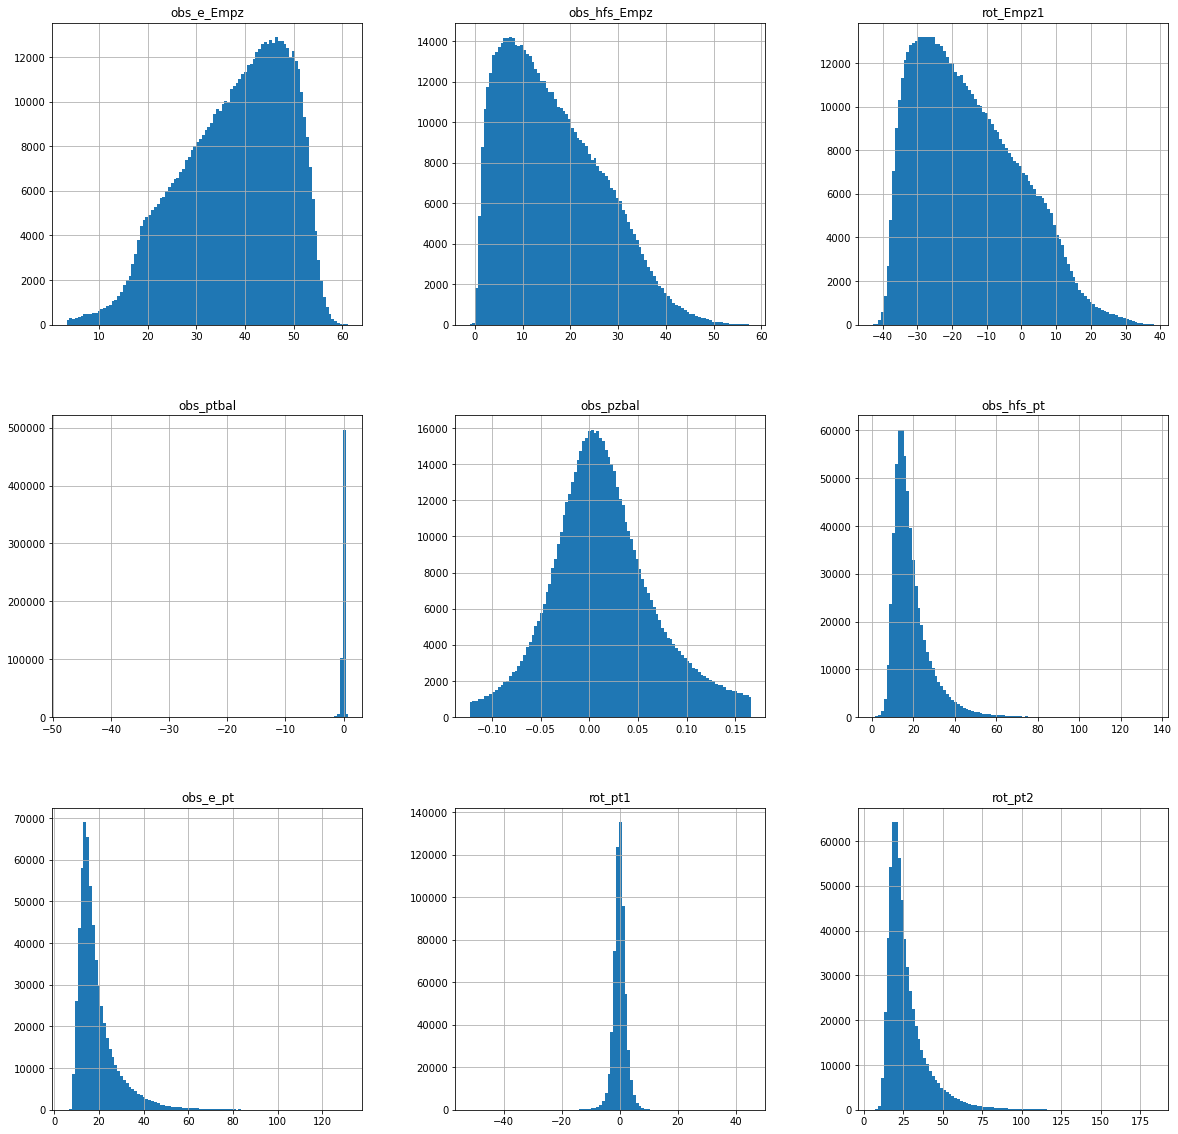

In [21]:
pandas_df_rapgap.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Django plots

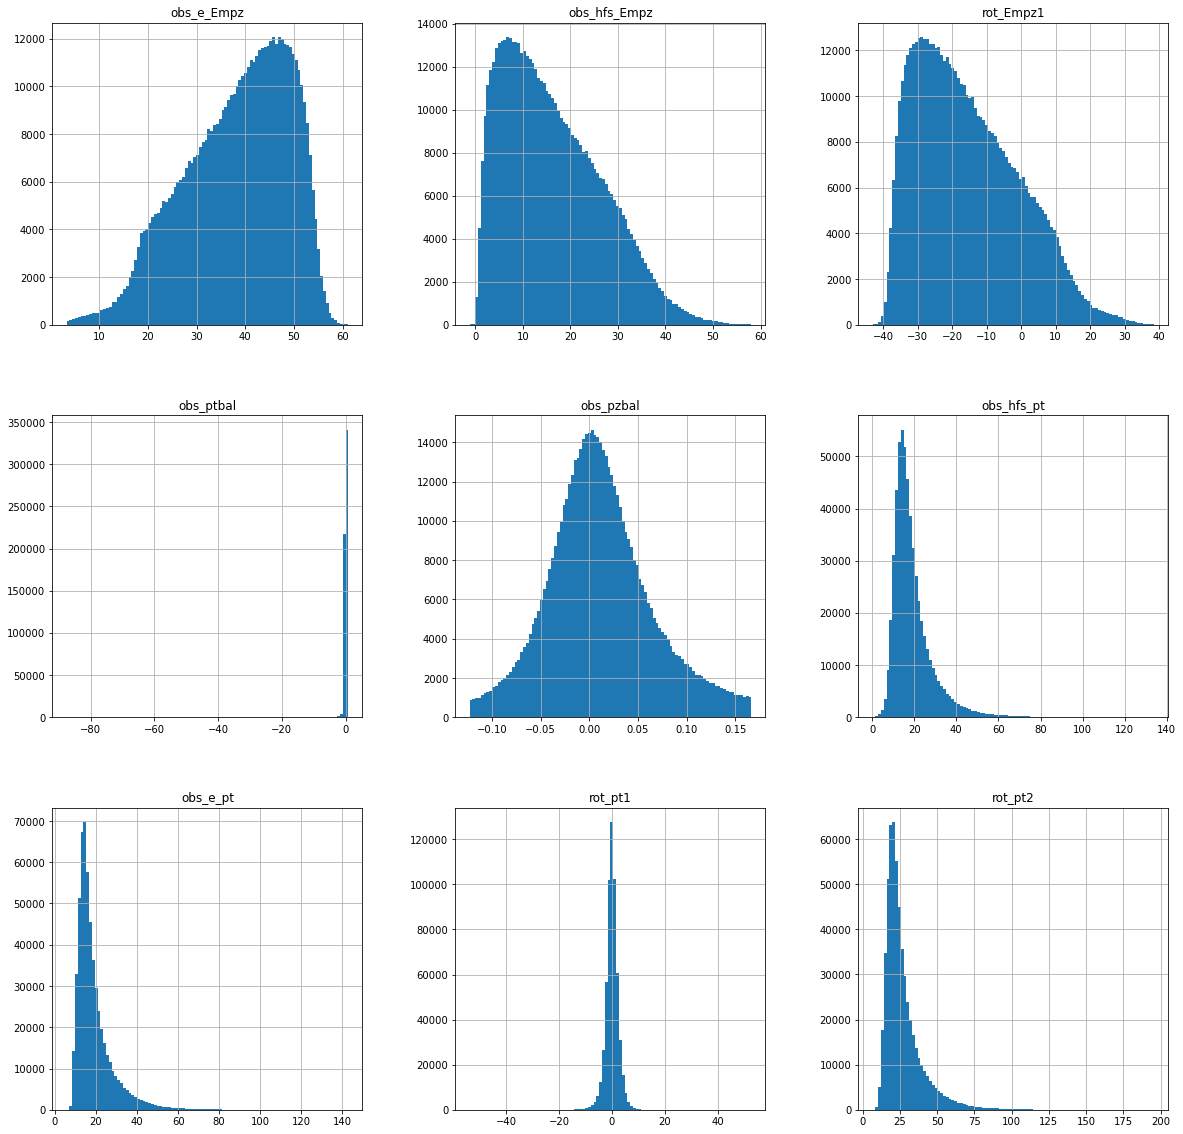

In [22]:
pandas_df_django.hist( figsize=(20,20), bins=100, column=[
    'obs_e_Empz','obs_hfs_Empz',
    'rot_Empz1',
#    'rot_Empz2',
    'obs_ptbal','obs_pzbal',
    'obs_hfs_pt','obs_e_pt',
    'rot_pt1','rot_pt2'] )

                                                   
plt.show()

## Comparison of Rapgap and Django

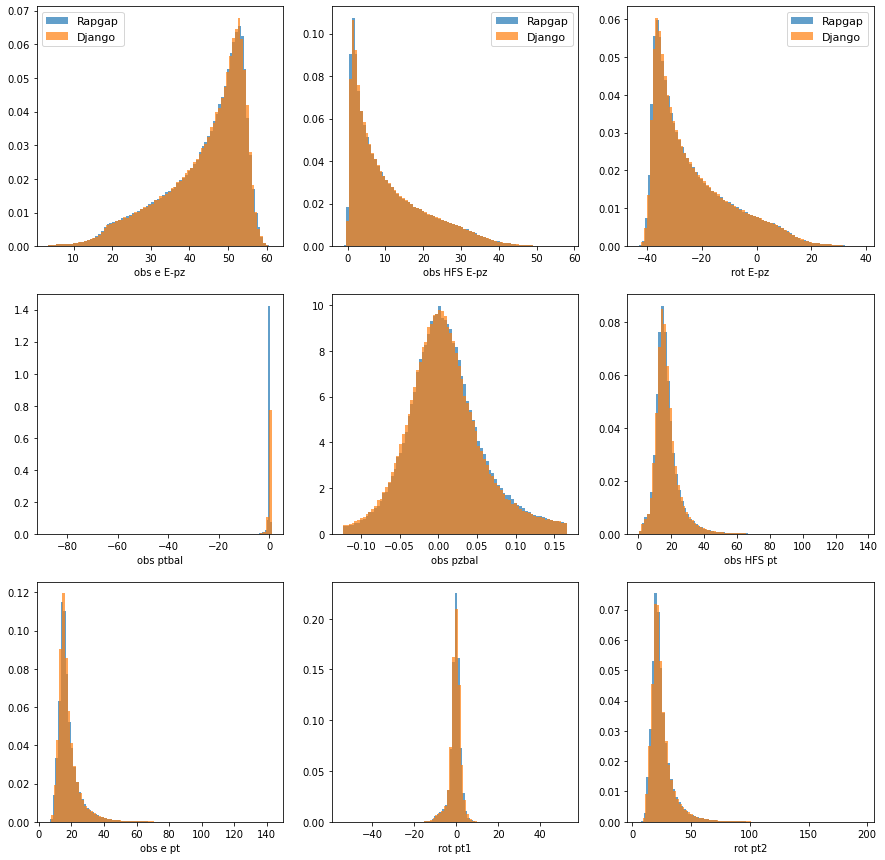

In [23]:
fig,ax = plt.subplots(3,3,figsize=(15,15))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_django['obs_e_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_Empz'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_django['obs_hfs_Empz'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[0][2].hist( pandas_df_rapgap['rot_Empz1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[0][2].hist( pandas_df_django['rot_Empz1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )




ax[1][0].hist( pandas_df_rapgap['obs_ptbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_django['obs_ptbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_pzbal'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_django['obs_pzbal'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[1][2].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[1][2].hist( pandas_df_django['obs_hfs_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )






ax[2][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][0].hist( pandas_df_django['obs_e_pt'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][1].hist( pandas_df_rapgap['rot_pt1'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][1].hist( pandas_df_django['rot_pt1'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )

ax[2][2].hist( pandas_df_rapgap['rot_pt2'], weights=pandas_df_rapgap['wgt'], label='Rapgap', density=True, bins=hbins, alpha=halpha )
ax[2][2].hist( pandas_df_django['rot_pt2'], weights=pandas_df_django['wgt'], label='Django', density=True, bins=hbins, alpha=halpha )







ax[0][0].set_xlabel('obs e E-pz')
ax[0][1].set_xlabel('obs HFS E-pz')
ax[0][2].set_xlabel('rot E-pz')

ax[1][0].set_xlabel('obs ptbal')
ax[1][1].set_xlabel('obs pzbal')
ax[1][2].set_xlabel('obs HFS pt')

ax[2][0].set_xlabel('obs e pt')
ax[2][1].set_xlabel('rot pt1')
ax[2][2].set_xlabel('rot pt2')




ax[0][0].legend( loc='best', fontsize=11)
ax[0][1].legend( loc='best', fontsize=11)
ax[0][2].legend( loc='best', fontsize=11)

plt.show()

## Rapgap, comparison of detector and particle (obs and gen)

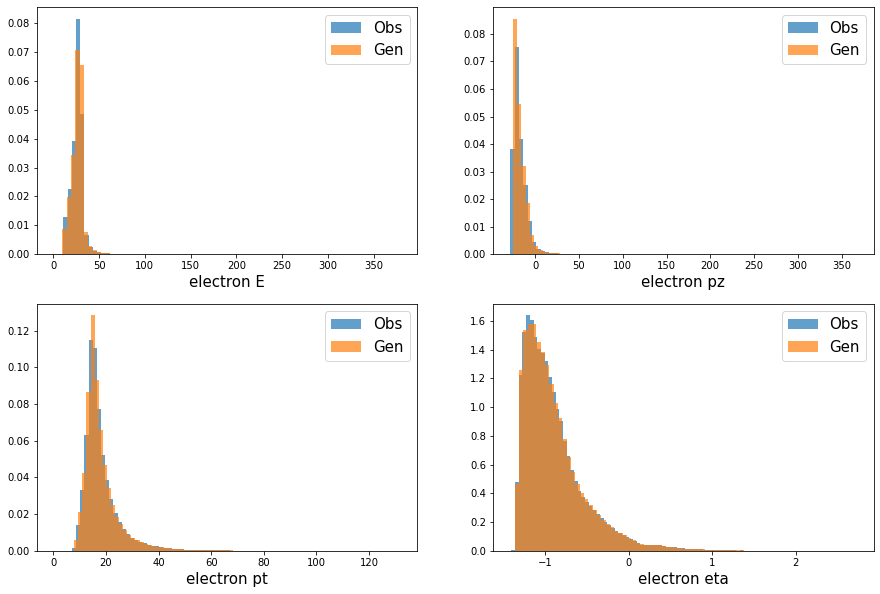

In [24]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_e_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_e_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_e_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_e_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_e_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_e_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_e_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_e_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )


hfontsize=15

ax[0][0].set_xlabel('electron E', fontsize=hfontsize)
ax[0][1].set_xlabel('electron pz', fontsize=hfontsize)

ax[1][0].set_xlabel('electron pt', fontsize=hfontsize)
ax[1][1].set_xlabel('electron eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)





plt.show()

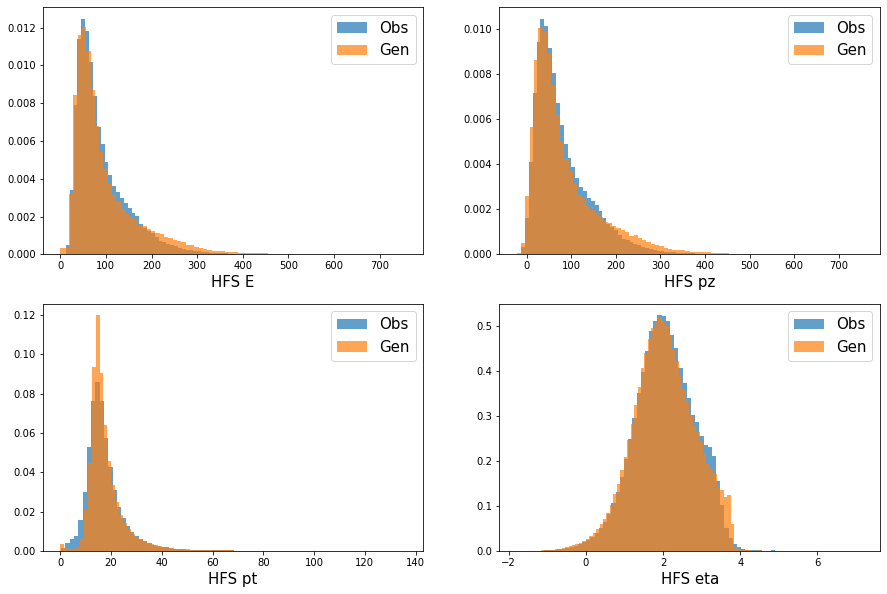

In [25]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

hbins=80
halpha=0.7




ax[0][0].hist( pandas_df_rapgap['obs_hfs_e'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][0].hist( pandas_df_rapgap['gen_hfs_etacut_e'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( pandas_df_rapgap['obs_hfs_pz'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[0][1].hist( pandas_df_rapgap['gen_hfs_etacut_pz'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_rapgap['obs_hfs_pt'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][0].hist( pandas_df_rapgap['gen_hfs_etacut_pt'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( pandas_df_rapgap['obs_hfs_eta'], weights=pandas_df_rapgap['wgt'], label='Obs', density=True, bins=hbins, alpha=halpha )
ax[1][1].hist( pandas_df_rapgap['gen_hfs_etacut_eta'], weights=pandas_df_rapgap['wgt'], label='Gen', density=True, bins=hbins, alpha=halpha )

hfontsize=15

ax[0][0].set_xlabel('HFS E', fontsize=hfontsize)
ax[0][1].set_xlabel('HFS pz', fontsize=hfontsize)

ax[1][0].set_xlabel('HFS pt', fontsize=hfontsize)
ax[1][1].set_xlabel('HFS eta', fontsize=hfontsize)

ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)

ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)



plt.show()

## Look at the distribution of event weights.

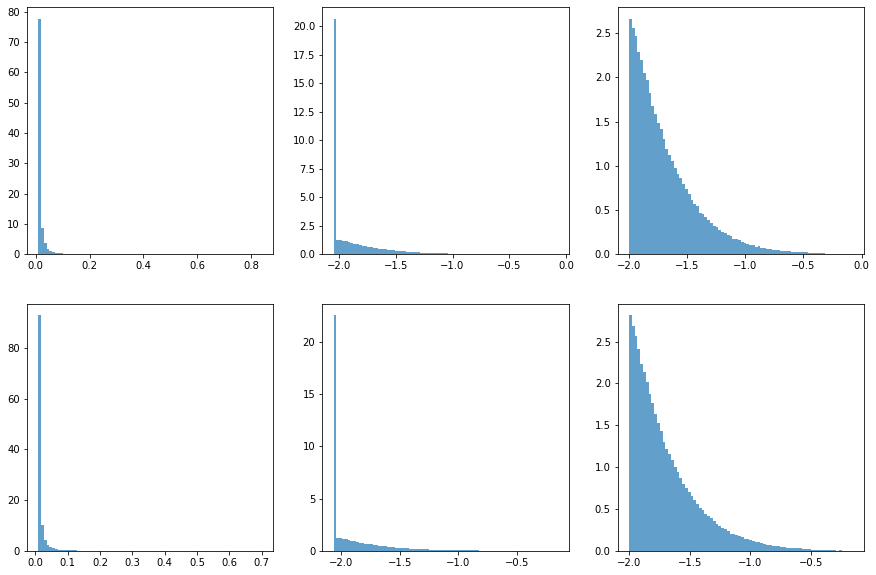

In [26]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

ax[0][0].hist( pandas_df_rapgap['wgt'], density=True, bins=hbins, alpha=halpha )

ax[0][1].hist( np.log10(pandas_df_rapgap['wgt']), density=True, bins=hbins, alpha=halpha )

ax[0][2].hist( np.log10(pandas_df_rapgap.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha )

ax[1][0].hist( pandas_df_django['wgt'], density=True, bins=hbins, alpha=halpha )

ax[1][1].hist( np.log10(pandas_df_django['wgt']), density=True, bins=hbins, alpha=halpha )

ax[1][2].hist( np.log10(pandas_df_django.query('wgt>0.01')['wgt']), density=True, bins=hbins, alpha=halpha )

plt.show()

## Set up machine learning stuff

In [27]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pickle import dump

#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


#####physical_devices = tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-25 15:55:33.925650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:33.942352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:33.942589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [28]:
X_gen_r = np.c_[
    pandas_df_rapgap['gen_e_e'].to_numpy(),
    pandas_df_rapgap['gen_e_pz'].to_numpy(),
    pandas_df_rapgap['gen_e_pt'].to_numpy(),
    pandas_df_rapgap['gen_e_eta'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_rapgap['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_rapgap['gen_dphi_etacut'].to_numpy(),
]

X_obs_r = np.c_[
    pandas_df_rapgap['obs_e_e'].to_numpy(),
    pandas_df_rapgap['obs_e_pz'].to_numpy(),
    pandas_df_rapgap['obs_e_pt'].to_numpy(),
    pandas_df_rapgap['obs_e_eta'].to_numpy(),
    pandas_df_rapgap['obs_hfs_e'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pz'].to_numpy(),
    pandas_df_rapgap['obs_hfs_pt'].to_numpy(),
    pandas_df_rapgap['obs_hfs_eta'].to_numpy(),
    pandas_df_rapgap['obs_dphi'].to_numpy(),
]


w_r = np.c_[
    pandas_df_rapgap['wgt'].to_numpy(),
]

Y_r = np.c_[
    np.ones(len(pandas_df_rapgap))
]

In [29]:
print(" shapes:  X_gen_r = %s , X_obs_r = %s , w_r = %s , Y_r = %s" % ( str(np.shape(X_gen_r)), str(np.shape(X_obs_r)), str(np.shape(w_r)), str(np.shape(Y_r)) ) )


 shapes:  X_gen_r = (613773, 9) , X_obs_r = (613773, 9) , w_r = (613773, 1) , Y_r = (613773, 1)


In [30]:
X_gen_d = np.c_[
    pandas_df_django['gen_e_e'].to_numpy(),
    pandas_df_django['gen_e_pz'].to_numpy(),
    pandas_df_django['gen_e_pt'].to_numpy(),
    pandas_df_django['gen_e_eta'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_e'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pz'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_pt'].to_numpy(),
    pandas_df_django['gen_hfs_etacut_eta'].to_numpy(),
    pandas_df_django['gen_dphi_etacut'].to_numpy(),
]

X_obs_d = np.c_[
    pandas_df_django['obs_e_e'].to_numpy(),
    pandas_df_django['obs_e_pz'].to_numpy(),
    pandas_df_django['obs_e_pt'].to_numpy(),
    pandas_df_django['obs_e_eta'].to_numpy(),
    pandas_df_django['obs_hfs_e'].to_numpy(),
    pandas_df_django['obs_hfs_pz'].to_numpy(),
    pandas_df_django['obs_hfs_pt'].to_numpy(),
    pandas_df_django['obs_hfs_eta'].to_numpy(),
    pandas_df_django['obs_dphi'].to_numpy(),
]




w_d = np.c_[
    pandas_df_django['wgt'].to_numpy(),
]

Y_d = np.c_[
    np.zeros(len(pandas_df_django))
]


In [31]:
print(" shapes:  X_gen_d = %s , X_obs_d = %s , w_d = %s , Y_d = %s" % ( str(np.shape(X_gen_d)), str(np.shape(X_obs_d)), str(np.shape(w_d)), str(np.shape(Y_d)) ) )

 shapes:  X_gen_d = (564057, 9) , X_obs_d = (564057, 9) , w_d = (564057, 1) , Y_d = (564057, 1)


In [32]:
X_gen = np.concatenate( [X_gen_r, X_gen_d] )
X_obs = np.concatenate( [X_obs_r, X_obs_d] )
w = np.concatenate( [w_r, w_d])
Y = np.concatenate( [Y_r, Y_d])

In [33]:
print(" shapes:  X_gen = %s , X_obs = %s ,  w = %s , Y = %s" % ( str(np.shape(X_gen)),  str(np.shape(X_obs)), str(np.shape(w)), str(np.shape(Y)) ) )

 shapes:  X_gen = (1177830, 9) , X_obs = (1177830, 9) ,  w = (1177830, 1) , Y = (1177830, 1)


In [34]:
X_gen

array([[ 23.27876663, -16.51725578,  16.40369606, ...,  16.67554092,
          1.93788922,   3.20208526],
       [ 13.49057484,  -9.36167717,   9.71362972, ...,   9.75612164,
          2.02149129,   3.16630697],
       [ 24.10554504, -19.99560928,  13.46301937, ...,  13.40249443,
          1.97886217,   3.16057396],
       ...,
       [ 57.31091309,   5.26610613,  57.06845856, ...,  56.59249878,
          2.95949411,   3.13959432],
       [ 18.31459999,  -7.90270472,  16.52186012, ...,  16.62121964,
          1.2708863 ,   3.09988546],
       [ 23.50551033, -15.97074509,  17.2465744 , ...,  18.2353096 ,
          1.8383379 ,   3.1121409 ]])

In [35]:
X_obs

array([[ 24.247692 , -17.285646 ,  17.004618 , ...,  18.103865 ,
          2.3029   ,   3.2084012],
       [ 13.34812  ,  -9.203184 ,   9.6681795, ...,   9.334386 ,
          2.4759128,   3.1380625],
       [ 25.104801 , -20.77686  ,  14.091598 , ...,  16.941334 ,
          1.0790696,   3.1579218],
       ...,
       [ 53.966328 ,   4.3972616,  53.78688  , ...,  49.605743 ,
          2.9379368,   3.1374125],
       [ 15.400095 ,  -6.822504 ,  13.806389 , ...,  17.172976 ,
          1.2826636,   2.995281 ],
       [ 22.97999  , -15.6631565,  16.815037 , ...,  15.914338 ,
          1.9772065,   3.1987998]], dtype=float32)

In [36]:
scalerX = StandardScaler()
scalerX.fit(X_gen)
Xs_gen = scalerX.transform(X_gen)
Xs_obs = scalerX.transform(X_obs)

In [37]:
X_gen_train, X_gen_test, X_obs_train, X_obs_test, Y_train, Y_test, w_train, w_test = train_test_split( Xs_gen, Xs_obs, Y, w, test_size=0.5 )

In [38]:
print("\n shapes:  X_gen_train = %s , X_obs_train = %s" % ( str(np.shape(X_gen_train)), str(np.shape(X_obs_train))))


 shapes:  X_gen_train = (588915, 9) , X_obs_train = (588915, 9)


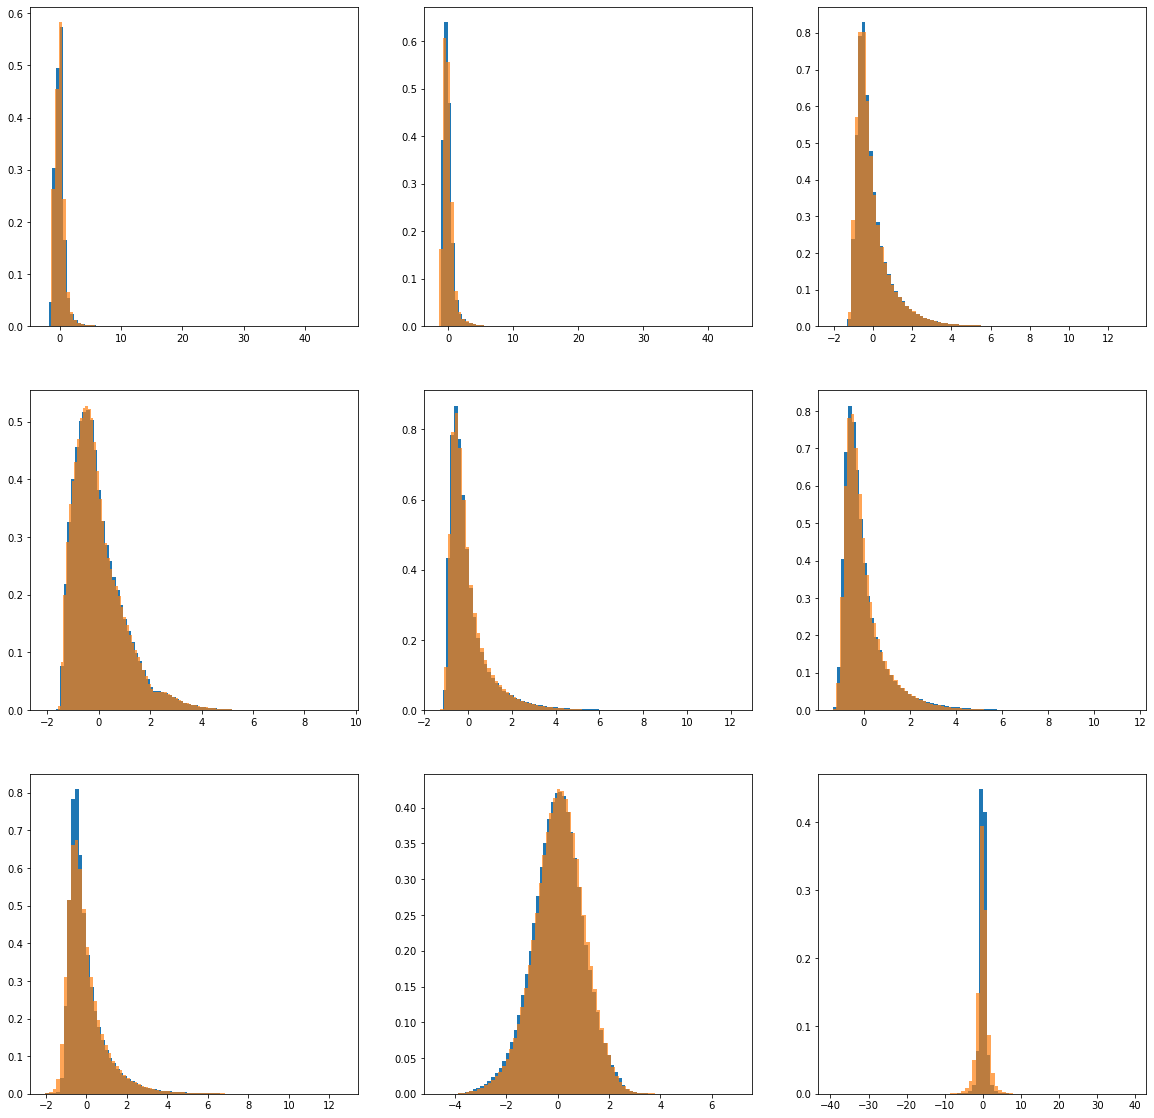

In [39]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7 )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7 )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7 )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7 )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7 )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins , alpha=0.7)

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7 )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins , alpha=0.7)
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7 )



plt.show()

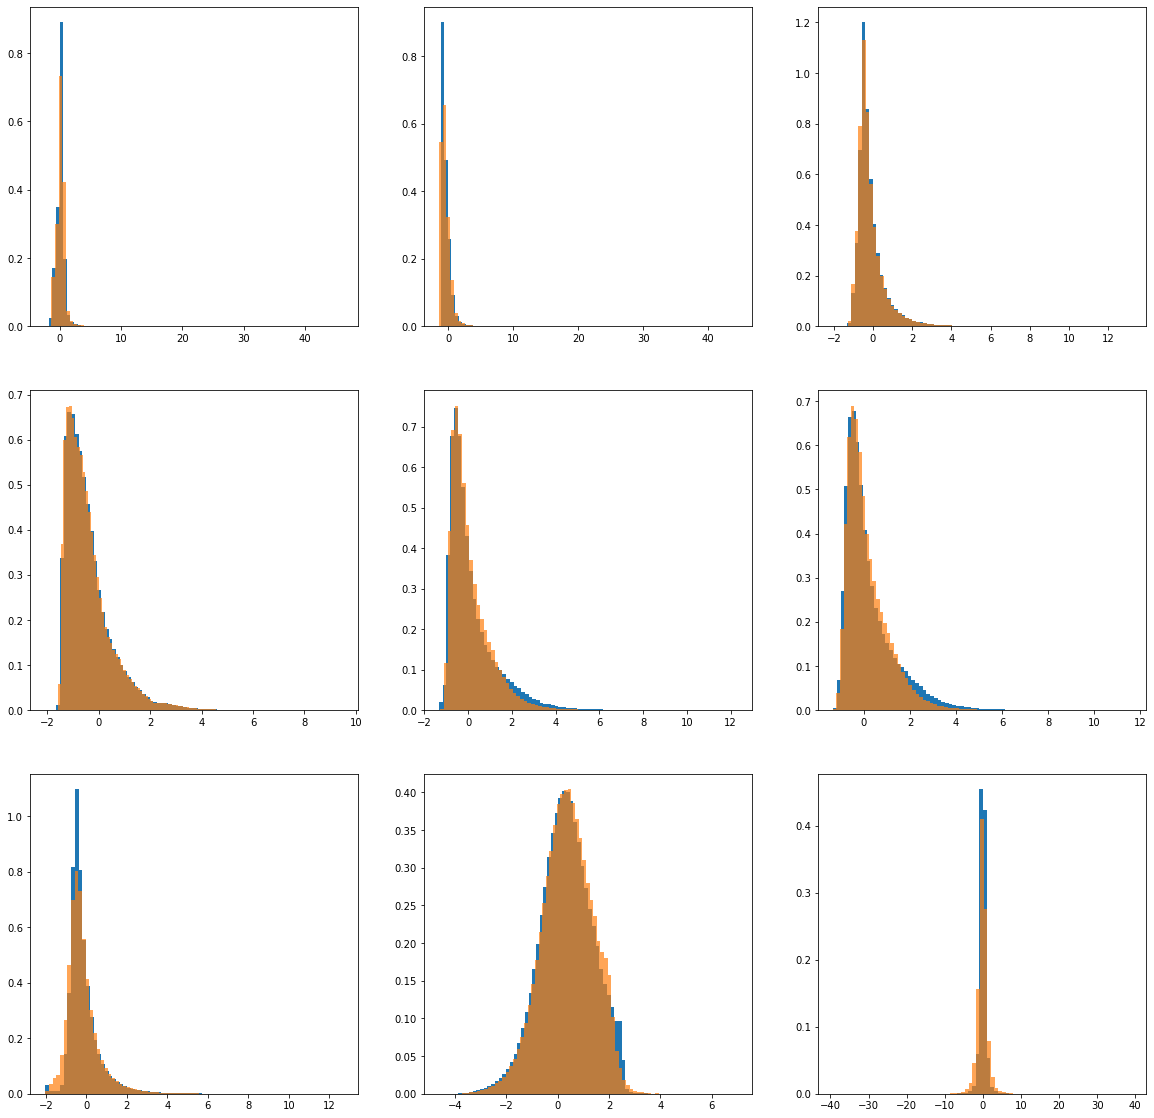

In [40]:
fig,ax = plt.subplots(3,3,figsize=(20,20))

hbins = 80


ax[0][0].hist( Xs_gen[:,0], density=True, bins=hbins, weights=w )
ax[0][1].hist( Xs_gen[:,1], density=True, bins=hbins, weights=w )
ax[0][2].hist( Xs_gen[:,2], density=True, bins=hbins, weights=w )

ax[1][0].hist( Xs_gen[:,3], density=True, bins=hbins, weights=w )
ax[1][1].hist( Xs_gen[:,4], density=True, bins=hbins, weights=w )
ax[1][2].hist( Xs_gen[:,5], density=True, bins=hbins, weights=w )

ax[2][0].hist( Xs_gen[:,6], density=True, bins=hbins, weights=w )
ax[2][1].hist( Xs_gen[:,7], density=True, bins=hbins, weights=w )
ax[2][2].hist( Xs_gen[:,8], density=True, bins=hbins, weights=w )



ax[0][0].hist( Xs_obs[:,0], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][1].hist( Xs_obs[:,1], density=True, bins=hbins, alpha=0.7, weights=w )
ax[0][2].hist( Xs_obs[:,2], density=True, bins=hbins, alpha=0.7, weights=w )

ax[1][0].hist( Xs_obs[:,3], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][1].hist( Xs_obs[:,4], density=True, bins=hbins, alpha=0.7, weights=w )
ax[1][2].hist( Xs_obs[:,5], density=True, bins=hbins, alpha=0.7, weights=w )

ax[2][0].hist( Xs_obs[:,6], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][1].hist( Xs_obs[:,7], density=True, bins=hbins, alpha=0.7, weights=w )
ax[2][2].hist( Xs_obs[:,8], density=True, bins=hbins, alpha=0.7, weights=w )



plt.show()

In [41]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    return K.mean(t_loss)

def weighted_mse(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    return K.mean(weights*(y_true - y_pred)**2)

## Simple classifier (Django vs Rapgap), using only particle-level features

In [42]:
model = Sequential()
model.add(Dense(50, input_dim=9, activation='relu')) 
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-06-25 15:55:38.596678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:38.596921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:38.597092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:38.973283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-25 15:55:38.973501: I tensorflow/compiler/xla/stream_executo

In [43]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [44]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(650, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
#model = Sequential()
#model.add(Dense(150, input_dim=9, activation='relu')) 
#model.add(Dense(350, activation='relu'))
#model.add(Dense(550, activation='relu'))
#model.add(Dense(850, activation='relu'))
#model.add(Dense(350, activation='relu'))
#model.add(Dense(150, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=20,
               verbose=True,
               restore_best_weights=True)

In [48]:
#hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=1024,verbose = 1)
#hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=2048,verbose = 1)
#hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=4096,verbose = 1)
#hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8192,verbose = 1)

#hist = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=8192,
#                 verbose = 1, callbacks=[earlystopping] )

#hist = model.fit(X_gen_train, Y_train, validation_data=(X_gen_test, Y_test), epochs=200, batch_size=4096,
#                 verbose = 1, callbacks=[earlystopping] )

hist = model.fit(X_obs_train, Y_train, validation_data=(X_obs_test, Y_test), epochs=200, batch_size=4096,
                 verbose = 1, callbacks=[earlystopping] )

Epoch 1/200


2023-06-25 15:55:39.995941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-25 15:55:39.998033: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f41c229d280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-25 15:55:39.998044: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-25 15:55:40.001375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-25 15:55:40.086188: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 [==============================] - 2s 4ms/step - loss: 0.6788 - accuracy: 0.5758 - val_loss: 0.6764 - val_accuracy: 0.5821
Epoch 2/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6753 - accuracy: 0.5829 - val_loss: 0.6750 - val_accuracy: 0.5835
Epoch 3/200
144/144 [==============================] - 0s 3ms/step - loss: 0.6745 - accuracy: 0.5843 - val_loss: 0.6745 - val_accuracy: 0.5836
Epoch 4/200
144/144 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5846 - val_loss: 0.6743 - val_accuracy: 0.5843
Epoch 5/200
144/144 [==============================] - 1s 3ms/step - loss: 0.6739 - accuracy: 0.5849 - val_loss: 0.6741 - val_accuracy: 0.5848
Epoch 6/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6737 - accuracy: 0.5851 - val_loss: 0.6741 - val_accuracy: 0.5843
Epoch 7/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6736 - accuracy: 0.5852 - val_loss: 0.6740 - val_accuracy: 0.5847
Epoch 8/200

144/144 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.5881 - val_loss: 0.6731 - val_accuracy: 0.5864
Epoch 59/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.5881 - val_loss: 0.6732 - val_accuracy: 0.5857
Epoch 60/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.5882 - val_loss: 0.6731 - val_accuracy: 0.5861
Epoch 61/200
144/144 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5884 - val_loss: 0.6731 - val_accuracy: 0.5859
Epoch 62/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6719 - accuracy: 0.5885 - val_loss: 0.6733 - val_accuracy: 0.5858
Epoch 63/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6719 - accuracy: 0.5880 - val_loss: 0.6736 - val_accuracy: 0.5851
Epoch 64/200
144/144 [==============================] - 1s 4ms/step - loss: 0.6719 - accuracy: 0.5881 - val_loss: 0.6734 - val_accuracy: 0.5859
Epoch

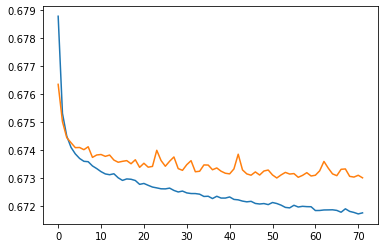

In [49]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [50]:
classifier_output_gen = model.predict( X_gen_test, batch_size=1024)
classifier_output_obs = model.predict( X_obs_test, batch_size=1024)

576/576 [==============================] - 0s 526us/step


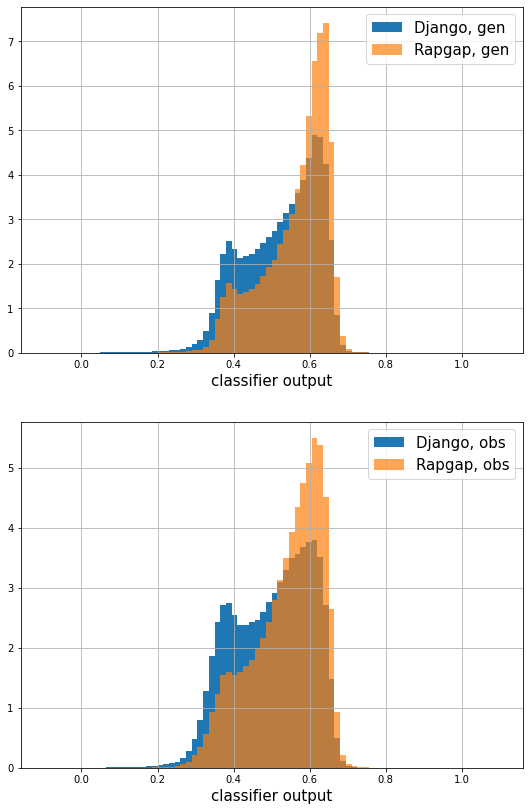

In [51]:
fig,ax = plt.subplots(2,1,figsize=(9,14))

hist0 = ax[0].hist( classifier_output_gen[Y_test==0], density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
hist1 = ax[0].hist( classifier_output_gen[Y_test==1], density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)

hist0_obs = ax[1].hist( classifier_output_obs[Y_test==0], density=True, bins=80, range=[-0.1,1.1], label='Django, obs')
hist1_obs = ax[1].hist( classifier_output_obs[Y_test==1], density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[0].grid()
ax[1].grid()


hfontsize=15

ax[0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1].set_xlabel('classifier output', fontsize=hfontsize)



ax[0].legend( loc='best', fontsize=hfontsize)
ax[1].legend( loc='best', fontsize=hfontsize)

plt.show()

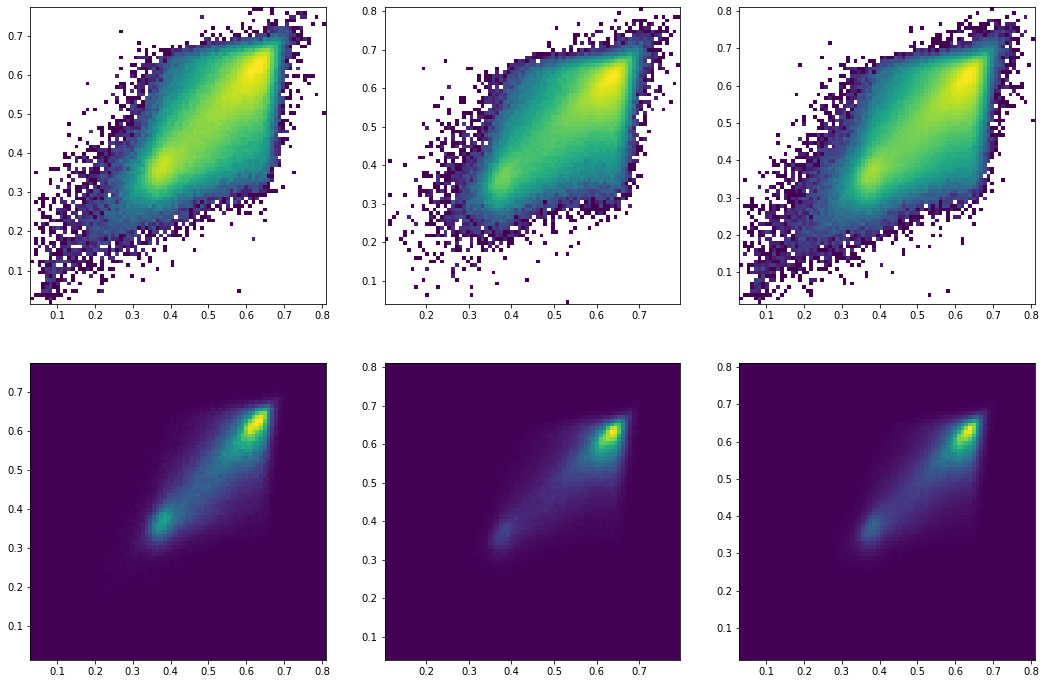

In [52]:
fig,ax = plt.subplots(2,3,figsize=(18,12))

ax[0][0].hist2d( classifier_output_gen[Y_test==0], classifier_output_obs[Y_test==0], bins=80, norm=mpl.colors.LogNorm())
ax[0][1].hist2d( classifier_output_gen[Y_test==1], classifier_output_obs[Y_test==1], bins=80, norm=mpl.colors.LogNorm())
ax[0][2].hist2d( classifier_output_gen[Y_test>-1], classifier_output_obs[Y_test>-1], bins=80, norm=mpl.colors.LogNorm())

ax[1][0].hist2d( classifier_output_gen[Y_test==0], classifier_output_obs[Y_test==0], bins=80)
ax[1][1].hist2d( classifier_output_gen[Y_test==1], classifier_output_obs[Y_test==1], bins=80)
ax[1][2].hist2d( classifier_output_gen[Y_test>-1], classifier_output_obs[Y_test>-1], bins=80)


plt.show()

In [53]:
from sklearn.metrics import roc_curve, auc,roc_auc_score

In [54]:
fpr, tpr, _ = roc_curve( Y_test, classifier_output_gen)

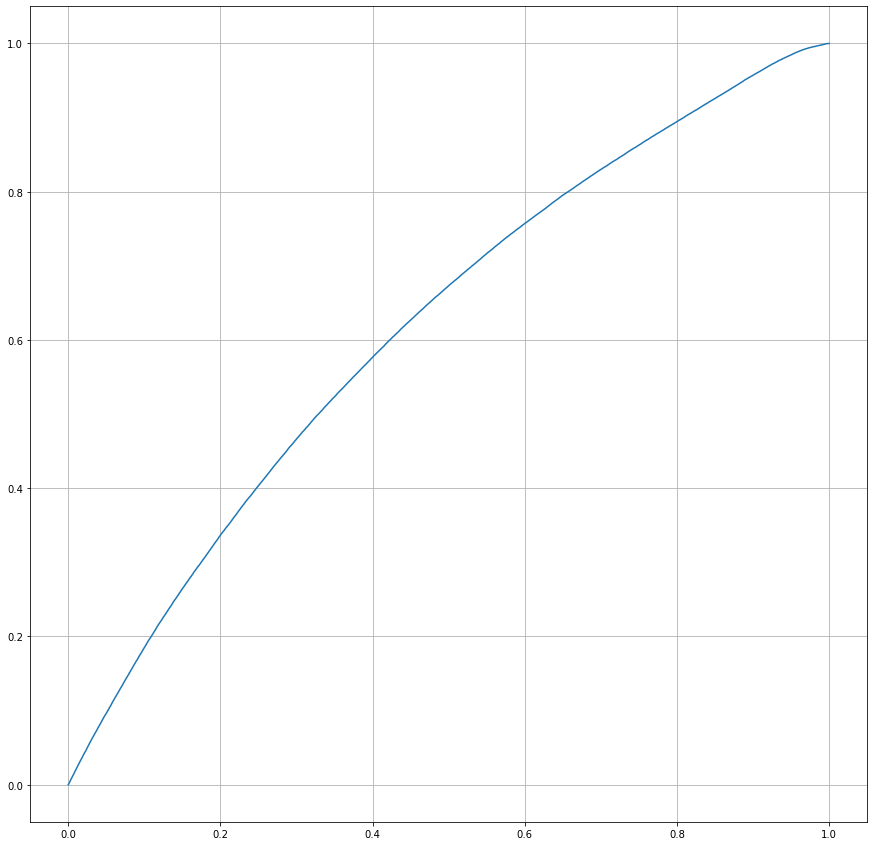

In [55]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.plot( fpr, tpr)
plt.grid()
plt.show()

In [56]:
hist0

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.72186986e-04, 2.12484144e-03, 5.90233879e-03, 1.01520202e-02,
        1.55821705e-02, 1.27490486e-02, 1.51099836e-02, 1.44017031e-02,
        1.41656096e-02, 1.58182640e-02, 2.40815363e-02, 3.02199671e-02,
        3.18726216e-02, 3.91915199e-02, 5.09961945e-02, 5.85512445e-02,
        8.92432517e-02, 1.24421394e-01, 1.96429591e-01, 2.94644972e-01,
        4.83046807e-01, 9.03058508e-01, 1.63919549e+00, 2.22258635e+00,
        2.50353291e+00, 2.32599540e+00, 2.13475524e+00, 2.16922917e+00,
        2.22872036e+00, 2.32434275e+00, 2.47047986e+00, 2.59490616e+00,
        2.72759084e+00, 2.92874269e+00, 3.14876953e+00, 3.34686468e+00,
        3.59641575e+00, 3.88964416e+00, 4.38636794e+00, 4.89020938e+00,
        4.84015751e+00, 4.25086757e+00, 2.52855378e+00, 8.37660546e-01,
        1.83208733e-01, 3.94276525e-02, 1.27490106e-02, 6.138436

In [57]:
len(hist0[0])

80

In [58]:
sum(hist0[0])

66.66666658737134

In [59]:
sum(hist1[0])

66.66666528183173

In [60]:
import numpy as np

In [61]:
total0 = sum(hist0[0])
total1 = sum(hist1[0])

npoints = len(hist0[0])
print('Number of points: %d' % npoints)

fr0 = np.zeros(npoints)
fr1 = np.zeros(npoints)

sum0 = float(0)
sum1 = float(0)

for i in range(npoints):
    sum0 += hist0[0][i]
    sum1 += hist1[0][i]
    fr0[i] = 1. - sum0/total0
    fr1[i] = 1. - sum1/total1
    print("  %2d :  fr0 = %7.3f  fr1 = %7.3f" % (i, fr0[i], fr1[i]))

Number of points: 80
   0 :  fr0 =   1.000  fr1 =   1.000
   1 :  fr0 =   1.000  fr1 =   1.000
   2 :  fr0 =   1.000  fr1 =   1.000
   3 :  fr0 =   1.000  fr1 =   1.000
   4 :  fr0 =   1.000  fr1 =   1.000
   5 :  fr0 =   1.000  fr1 =   1.000
   6 :  fr0 =   1.000  fr1 =   1.000
   7 :  fr0 =   1.000  fr1 =   1.000
   8 :  fr0 =   1.000  fr1 =   1.000
   9 :  fr0 =   1.000  fr1 =   1.000
  10 :  fr0 =   1.000  fr1 =   1.000
  11 :  fr0 =   1.000  fr1 =   1.000
  12 :  fr0 =   0.999  fr1 =   1.000
  13 :  fr0 =   0.999  fr1 =   1.000
  14 :  fr0 =   0.999  fr1 =   1.000
  15 :  fr0 =   0.999  fr1 =   1.000
  16 :  fr0 =   0.999  fr1 =   1.000
  17 :  fr0 =   0.998  fr1 =   1.000
  18 :  fr0 =   0.998  fr1 =   1.000
  19 :  fr0 =   0.998  fr1 =   1.000
  20 :  fr0 =   0.997  fr1 =   1.000
  21 :  fr0 =   0.997  fr1 =   1.000
  22 :  fr0 =   0.996  fr1 =   0.999
  23 :  fr0 =   0.995  fr1 =   0.999
  24 :  fr0 =   0.994  fr1 =   0.999
  25 :  fr0 =   0.992  fr1 =   0.998
  26 :  fr0 =   0

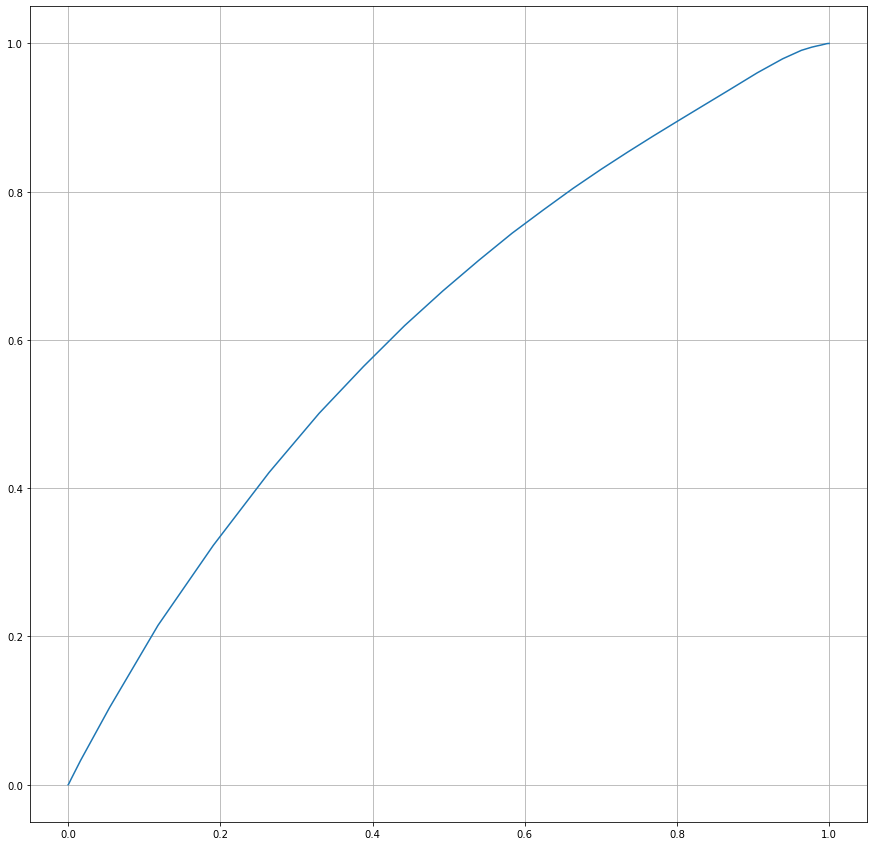

In [62]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
plt.plot( fr0, fr1)
plt.grid()
plt.show()

## Classifier (Django vs Rapgap) with adversarial NN that penalizes gen vs obs discrimination.

In [63]:
X_gen_and_obs = np.concatenate( [X_gen_r, X_gen_d, X_obs_r, X_obs_d] )
w_gen_and_obs = np.concatenate( [w_r, w_d, w_r, w_d])
Y_gen_and_obs = np.concatenate( [Y_r, Y_d, Y_r, Y_d])
Z_gen_and_obs = np.concatenate( [np.zeros(len(X_gen_r)), np.zeros(len(X_gen_d)), np.ones(len(X_obs_r)), np.ones(len(X_obs_d))])

In [64]:
scalerX_gen_and_obs = StandardScaler()
scalerX_gen_and_obs.fit(X_gen_and_obs)
Xs_gen_and_obs = scalerX_gen_and_obs.transform(X_gen_and_obs)

In [65]:
X_gen_and_obs_train, X_gen_and_obs_test, Y_gen_and_obs_train, Y_gen_and_obs_test, Z_gen_and_obs_train, Z_gen_and_obs_test, w_gen_and_obs_train, w_gen_and_obs_test = train_test_split( Xs_gen_and_obs, Y_gen_and_obs, Z_gen_and_obs, w_gen_and_obs, test_size=0.5 )

In [66]:
print("\n shapes:  X_gen_and_obs_train = %s " % str(np.shape(X_gen_and_obs_train)) )
print(" shapes:  Y_gen_and_obs_train = %s " % str(np.shape(Y_gen_and_obs_train)) )
print(" shapes:  Z_gen_and_obs_train = %s \n" % str(np.shape(Z_gen_and_obs_train)) )


 shapes:  X_gen_and_obs_train = (1177830, 9) 
 shapes:  Y_gen_and_obs_train = (1177830, 1) 
 shapes:  Z_gen_and_obs_train = (1177830,) 



In [67]:
@tf.custom_gradient
def grad_reverse(x, scale=10.):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy * scale
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super(GradReverse, self).__init__()

    def call(self, x):
        return grad_reverse(x)

In [68]:
n_hidden_inv = 2; n_hidden_inv_R = 5
n_nodes_inv = 50; n_nodes_inv_R = 50
hp_lambda = 10.

inputs = Input(shape=(9,))
inputs_label = Input(shape=(1,))

Dx = Dense(n_nodes_inv, activation="relu")(inputs)
for i in range(n_hidden_inv -1):
    Dx = Dense(n_nodes_inv, activation='relu')(Dx)
Dx = Dense(1, activation="sigmoid", name="Clf")(Dx)
inv_model = Model(inputs=inputs, outputs=Dx)

GRx = GradReverse()(Dx)
GRx_con = tf.keras.layers.concatenate([GRx,inputs_label])
Rx = Dense(n_nodes_inv_R, activation="relu")(GRx_con)
for i in range(n_hidden_inv_R -1):
    Rx = Dense(n_nodes_inv_R, activation='relu')(Rx)

Rx = Dense(1, activation="sigmoid", name="Adv")(Rx)
GR = Model(inputs=[inputs,inputs_label], outputs=[Dx, Rx])

GR.compile(loss=["binary_crossentropy", "binary_crossentropy"], loss_weights=[1,hp_lambda], optimizer="adam") #rmsprop

In [69]:
GRhist = GR.fit(x=[X_gen_and_obs_train, Y_gen_and_obs_train], 
                y=[Y_gen_and_obs_train, Z_gen_and_obs_train], 
                validation_data=([X_gen_and_obs_test, Y_gen_and_obs_test],[Y_gen_and_obs_test, Z_gen_and_obs_test]),
                epochs=200, batch_size=2048, verbose = 1, callbacks=[earlystopping] )

Epoch 1/200
576/576 [==============================] - 5s 6ms/step - loss: 7.6168 - Clf_loss: 0.6855 - Adv_loss: 0.6931 - val_loss: 7.6150 - val_Clf_loss: 0.6834 - val_Adv_loss: 0.6932
Epoch 2/200
576/576 [==============================] - 3s 6ms/step - loss: 7.6133 - Clf_loss: 0.6817 - Adv_loss: 0.6932 - val_loss: 7.6128 - val_Clf_loss: 0.6812 - val_Adv_loss: 0.6932
Epoch 3/200
576/576 [==============================] - 3s 6ms/step - loss: 7.6113 - Clf_loss: 0.6797 - Adv_loss: 0.6932 - val_loss: 7.6087 - val_Clf_loss: 0.6773 - val_Adv_loss: 0.6931
Epoch 4/200
576/576 [==============================] - 3s 6ms/step - loss: 7.6111 - Clf_loss: 0.6794 - Adv_loss: 0.6932 - val_loss: 7.6168 - val_Clf_loss: 0.6841 - val_Adv_loss: 0.6933
Epoch 5/200
576/576 [==============================] - 3s 6ms/step - loss: 7.6090 - Clf_loss: 0.6774 - Adv_loss: 0.6932 - val_loss: 7.6070 - val_Clf_loss: 0.6755 - val_Adv_loss: 0.6932
Epoch 6/200
576/576 [==============================] - 3s 6ms/step - loss: 

576/576 [==============================] - 3s 6ms/step - loss: 7.5931 - Clf_loss: 0.6616 - Adv_loss: 0.6932 - val_loss: 7.5924 - val_Clf_loss: 0.6609 - val_Adv_loss: 0.6931
Epoch 46/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5930 - Clf_loss: 0.6615 - Adv_loss: 0.6931 - val_loss: 7.5925 - val_Clf_loss: 0.6611 - val_Adv_loss: 0.6931
Epoch 47/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5931 - Clf_loss: 0.6616 - Adv_loss: 0.6931 - val_loss: 7.5924 - val_Clf_loss: 0.6609 - val_Adv_loss: 0.6931
Epoch 48/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5930 - Clf_loss: 0.6615 - Adv_loss: 0.6931 - val_loss: 7.5925 - val_Clf_loss: 0.6610 - val_Adv_loss: 0.6932
Epoch 49/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5929 - Clf_loss: 0.6614 - Adv_loss: 0.6931 - val_loss: 7.5923 - val_Clf_loss: 0.6608 - val_Adv_loss: 0.6931
Epoch 50/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5928 

576/576 [==============================] - 3s 6ms/step - loss: 7.5919 - Clf_loss: 0.6604 - Adv_loss: 0.6932 - val_loss: 7.5915 - val_Clf_loss: 0.6600 - val_Adv_loss: 0.6931
Epoch 90/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5919 - Clf_loss: 0.6604 - Adv_loss: 0.6931 - val_loss: 7.5917 - val_Clf_loss: 0.6602 - val_Adv_loss: 0.6931
Epoch 91/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5919 - Clf_loss: 0.6604 - Adv_loss: 0.6931 - val_loss: 7.5918 - val_Clf_loss: 0.6603 - val_Adv_loss: 0.6932
Epoch 92/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5918 - Clf_loss: 0.6603 - Adv_loss: 0.6931 - val_loss: 7.5917 - val_Clf_loss: 0.6600 - val_Adv_loss: 0.6932
Epoch 93/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5919 - Clf_loss: 0.6604 - Adv_loss: 0.6932 - val_loss: 7.5918 - val_Clf_loss: 0.6604 - val_Adv_loss: 0.6931
Epoch 94/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5918 

Epoch 133/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5901 - Clf_loss: 0.6586 - Adv_loss: 0.6932 - val_loss: 7.5900 - val_Clf_loss: 0.6585 - val_Adv_loss: 0.6931
Epoch 134/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5901 - Clf_loss: 0.6586 - Adv_loss: 0.6932 - val_loss: 7.5897 - val_Clf_loss: 0.6583 - val_Adv_loss: 0.6931
Epoch 135/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5899 - Clf_loss: 0.6585 - Adv_loss: 0.6931 - val_loss: 7.5897 - val_Clf_loss: 0.6582 - val_Adv_loss: 0.6932
Epoch 136/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5899 - Clf_loss: 0.6584 - Adv_loss: 0.6931 - val_loss: 7.5898 - val_Clf_loss: 0.6584 - val_Adv_loss: 0.6931
Epoch 137/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5898 - Clf_loss: 0.6583 - Adv_loss: 0.6931 - val_loss: 7.5896 - val_Clf_loss: 0.6582 - val_Adv_loss: 0.6931
Epoch 138/200
576/576 [==============================] - 3s 6ms/s

Epoch 177/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5877 - Clf_loss: 0.6562 - Adv_loss: 0.6932 - val_loss: 7.5877 - val_Clf_loss: 0.6562 - val_Adv_loss: 0.6932
Epoch 178/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5877 - Clf_loss: 0.6562 - Adv_loss: 0.6932 - val_loss: 7.5877 - val_Clf_loss: 0.6562 - val_Adv_loss: 0.6932
Epoch 179/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5876 - Clf_loss: 0.6561 - Adv_loss: 0.6931 - val_loss: 7.5878 - val_Clf_loss: 0.6563 - val_Adv_loss: 0.6931
Epoch 180/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5875 - Clf_loss: 0.6560 - Adv_loss: 0.6932 - val_loss: 7.5881 - val_Clf_loss: 0.6566 - val_Adv_loss: 0.6931
Epoch 181/200
576/576 [==============================] - 3s 6ms/step - loss: 7.5876 - Clf_loss: 0.6561 - Adv_loss: 0.6932 - val_loss: 7.5878 - val_Clf_loss: 0.6564 - val_Adv_loss: 0.6931
Epoch 182/200
576/576 [==============================] - 3s 6ms/s

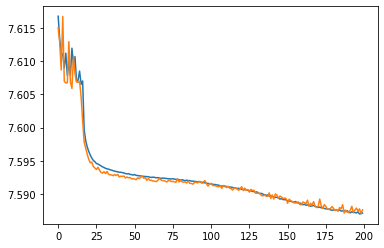

In [70]:
plt.plot(GRhist.history['loss'])
plt.plot(GRhist.history['val_loss'])

In [71]:
classifier_output_adv = inv_model.predict( X_gen_and_obs_test, batch_size=2048 )

576/576 [==============================] - 0s 511us/step


In [72]:
Xs_gen_d = scalerX_gen_and_obs.transform( X_gen_d )
Xs_obs_d = scalerX_gen_and_obs.transform( X_obs_d )
Xs_gen_r = scalerX_gen_and_obs.transform( X_gen_r )
Xs_obs_r = scalerX_gen_and_obs.transform( X_obs_r )




classifier_output_django_gen = inv_model.predict( Xs_gen_d, batch_size=2048 )
classifier_output_django_obs = inv_model.predict( Xs_obs_d, batch_size=2048 )
classifier_output_rapgap_gen = inv_model.predict( Xs_gen_r, batch_size=2048 )
classifier_output_rapgap_obs = inv_model.predict( Xs_obs_r, batch_size=2048 )

300/300 [==============================] - 0s 532us/step


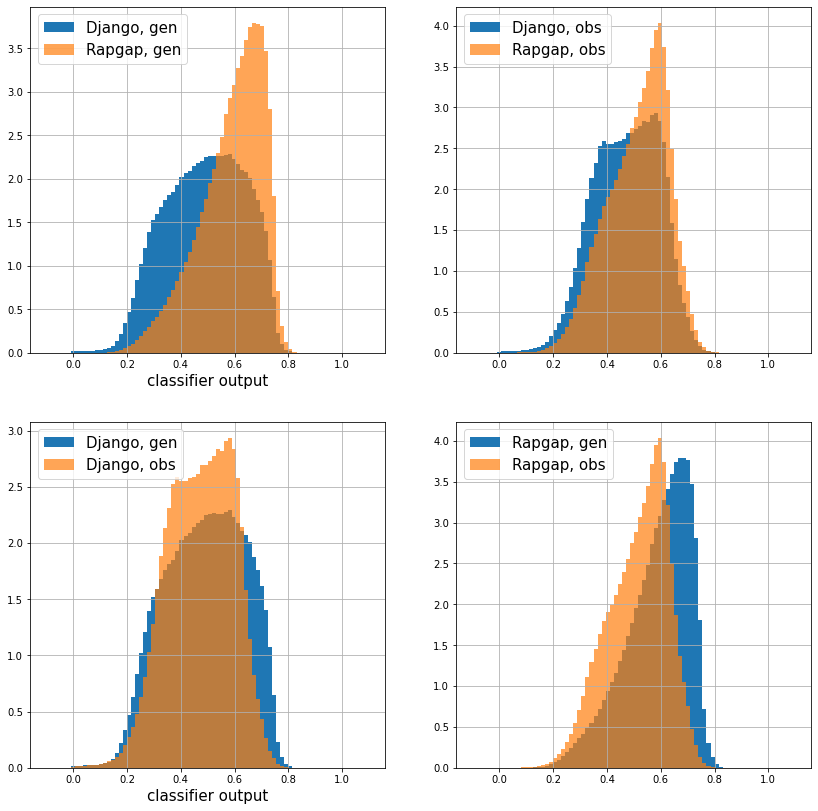

In [73]:
fig,ax = plt.subplots(2,2,figsize=(14,14))

ax[0][0].hist( classifier_output_django_gen, density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[0][0].hist( classifier_output_rapgap_gen, density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen', alpha=0.7)
      
ax[0][1].hist( classifier_output_django_obs, density=True, bins=80, range=[-0.1,1.1], label='Django, obs' )
ax[0][1].hist( classifier_output_rapgap_obs, density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7)

ax[1][0].hist( classifier_output_django_gen, density=True, bins=80, range=[-0.1,1.1], label='Django, gen' )
ax[1][0].hist( classifier_output_django_obs, density=True, bins=80, range=[-0.1,1.1], label='Django, obs', alpha=0.7 )


ax[1][1].hist( classifier_output_rapgap_gen, density=True, bins=80, range=[-0.1,1.1], label='Rapgap, gen' )
ax[1][1].hist( classifier_output_rapgap_obs, density=True, bins=80, range=[-0.1,1.1], label='Rapgap, obs', alpha=0.7 )




ax[0][0].grid()
ax[0][1].grid()
ax[1][0].grid()
ax[1][1].grid()



hfontsize=15

ax[0][0].set_xlabel('classifier output', fontsize=hfontsize)
ax[1][0].set_xlabel('classifier output', fontsize=hfontsize)




ax[0][0].legend( loc='best', fontsize=hfontsize)
ax[1][0].legend( loc='best', fontsize=hfontsize)
ax[0][1].legend( loc='best', fontsize=hfontsize)
ax[1][1].legend( loc='best', fontsize=hfontsize)


plt.show()